In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 40)

%matplotlib inline

In [2]:
data_directory = '../../../Data/2_eye/Game/Raw/'

In [27]:
class Tidy(object):
    def __init__(self, initials, sub_no=0):
        self.directory = data_directory
        self.subject = initials
        self.sub_no = sub_no
        
        self.gcols = [
            'idx', 'subid', 'color', 'gi', 'mi', 'status', 
            'bp', 'wp', 'zet', 'rt', 'tstamp', 
            'mouset', 'mousex', 'rt_comp', 'tstamp_comp'
        ]
        
        self.tcols = [
            'tstamp', 'mousex', 'mousey', 'dt', 'tile'
        ]
        
        self.D = self.load()
        self.T = self.make_tidy()
        
    def mouse_to_tile(self, x, y):
        top = 192
        bottom = 506
        left = 177
        right = 889
        height = bottom - top
        width = right - left
        newx = 9*(x - left) // width
        newy = 4*(y - top) // height

        return newx + 9*newy
        
    def load(self):
        # read csv
        d = pd.read_csv(
            '{}{}.csv'.format(self.directory, self.subject),
            names=self.gcols
        )
        
        # strip computer moves
        d = d.loc[d.rt.astype(int)>0, self.gcols[1:]]
        
        # add timestamp and rt for computer
        d.loc[:, 'tstamp_comp'] = d.tstamp.astype(int) - d.rt.astype(int)
        d.loc[:, 'rt_comp'] = d.tstamp_comp - d.tstamp.astype(int).shift(1)
        d.loc[:, 'subject'] = self.sub_no
        d = d.reset_index(drop=True)
        return d
    
    def make_tidy(self):
        ts = self.D.tstamp.astype(int)
        tidy = pd.DataFrame(
            index=np.arange(ts.max() + 1 - ts.min()), 
            columns=self.tcols
        )
        tidy.loc[:, 'tstamp'] = np.arange(ts.min(), ts.max()+1, 1)
        mt = self.D.loc[~pd.isnull(self.D.mouset), :]
        
        def expand_line(idx):
            mouset = np.array(mt.loc[idx, 'mouset'].split(',')).astype(int)
            mouset = mouset[mouset > int(mt.tstamp.values[0])]
            iterator = mt.loc[idx, 'mousex'].split(';')
            mousexy = np.array([xy.split(',') for xy in iterator]).astype(int)
            return mouset, mousexy
        
        for idx in mt.index.values:
            mouset, mousexy = expand_line(idx)
            tidy.loc[tidy.tstamp.isin(mouset), ['mousex', 'mousey']] = mousexy
        
        tidy = tidy.loc[pd.notnull(tidy.mousex), :]
        tidy.dt = (tidy.tstamp - tidy.tstamp.shift(1)).shift(-1)
        tidy.tile = self.mouse_to_tile(tidy.mousex, tidy.mousey)
        return tidy

In [28]:
inits = [f[:2] for f in os.listdir('../../../Data/2_eye/Game/Raw/') if f[-3:]=='csv']
t = Tidy(inits[0])

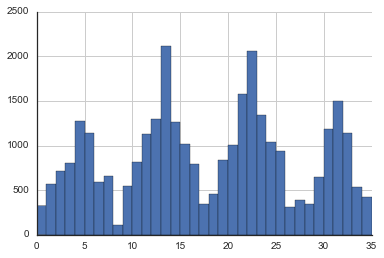

In [33]:
t.T.tile.hist(bins=np.arange(36))
sns.despine()

In [34]:
# looks good!